In [1]:
import csv
import nltk
import re
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

### Function to read data from the SPSS data file

In [2]:
def get_file_stats(filename):

    ''' 
    RETURNED VALUES:
        r_count = (int) number of rows (entries)
        fields = (list) field names
        alldata = (list of dicts) all data in dictionary form {field: value}
    '''
    new_dict = {}
    fields = []
    alldata=[]
    
    with open(filename, 'r', encoding='utf-8', errors='ignore') as csvfile:
#     with open(filename, 'rb') as csvfile:
        readerObj = csv.reader(csvfile)

        r_count=0
        c_count=0

        for row in readerObj:
            
            for column in row:
                if r_count==0:
#                     if column not in ('\ufeffEmbedded'):
                        fields.append(column)
                    
            for column in row:
                new_dict[fields[c_count]]=column
                c_count+=1
                
            alldata.append(new_dict)
            new_dict = {}
            
            c_count=0
            r_count+=1
        
            
    return (r_count, fields, alldata)

### Function to prepare the data for analysis

In [96]:
def DataPrep(alldata, CATEGORY1="mainTitle", CATEGORY2="", MIN_FREQ=10, PLOT=1):
    
    # Create a list of English language stop-words:
    sw = nltk.corpus.stopwords.words('english')
    # Customize the stop-words (mainly remove common first names that appear a lot):
    sw.extend(['maintitle','muhammed','john','paul','peter','mark', 'book'])

    words = []
    words_ne = []
    words_st = []
    titles = []
    
    #Go thru each title and...
    for n in range(nentries):
        # 1. Tokenize title
        title = alldata[n][CATEGORY1]
        if CATEGORY2 == '':
            titles.append(title)
        elif alldata[n]["Author_1_Gender"] == CATEGORY2:
            titles.append(title)
        token = re.findall('\w+', title)

        # 2. collect all words (as lower-case) into a list
        for word in token:
            words.append(word.lower())

    # 3. ammend the list to remove the stop-words, any word that's only 1 letter long, any word that's a number:
    for word in words:
        if (word not in sw) and (len(word) > 1) and (word[0] not in '0123456789') :
            words_ne.append(word)

    # 4. do word-stemming on the list of words
    for word in words_ne:
        ps = nltk.stem.PorterStemmer()
        words_st.append(ps.stem(word))

    # 5. Plot word frequency
    if PLOT == 1:
        sns.set_style('darkgrid')
        nlp_words = nltk.FreqDist(words_st)
        print("50 most frequently used words")
        plt.figure(figsize=(10,10))
        nlp_words.plot(50);

    # 6. create a list of words that appear >= 10 times:
    fword_list = []
    for fword in nlp_words:
        if nlp_words.freq(fword)*nlp_words.N() >= MIN_FREQ:
            fword_list.append(fword)
    print("There are", len(fword_list), "most-frequently used words where min. frequency is set to", MIN_FREQ)
    
    return (fword_list, titles)

### Function to prepare the adjacency data for SNA

In [101]:
def AdjacenyData(fword_list, titles, MIN_WEIGHT = 5):
    
    words_set = sorted(set(fword_list))
    
    networkdata = []
    for word1 in words_set:
        for word2 in words_set:
            if word1 != word2:
                count = 0
                for title in titles:
                    if word1 in title and word2 in title:
                        count += 1
                if count >= MIN_WEIGHT:
                    networkdata.append((word1, word2, count))

                rep = ([i for i, v in enumerate(networkdata) if v[0] == word1 and v[1] == word2] != [])\
             and ([i for i, v in enumerate(networkdata) if v[0] == word2 and v[1] == word1] != [])

                if rep:
                    networkdata.remove((word1, word2, count))
    
    print('range of edge weights:', max(networkdata, key=lambda item: item[2])[2], 'to', MIN_WEIGHT)   
    print('# of edges =', len(networkdata))
                        
    return networkdata

### Function to plot data

In [124]:
def PlotNetwork(networkdata):
    g = nx.Graph()
    for entry in networkdata:
        g.add_edge(entry[0], entry[1], weight=entry[2])

    plt.figure(figsize=(15,15))
    pos = nx.spring_layout(g)
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())

#     nx.draw_networkx(g, pos, node_size=300, edge_color=weights, edge_cmap=plt.cm.Greens, node_color='grey')
    nx.draw_networkx(g, pos, node_size=300, edge_color='grey', node_color='white')

    print('# of nodes =', g.number_of_nodes())
    print('network density =', round(nx.density(g),3))
    
    # Print centralities
    dcent = nx.degree_centrality(g)
    dcent = {k: v for k, v in sorted(dcent.items(), key=lambda item: item[1], reverse=True)}
    ecent = nx.eigenvector_centrality(g)
    bcent = nx.betweenness_centrality(g)
    
    print("\n*** CENTRALITY MEASURES, sorted by degree centrality")
    print('{:12}'.format('NODE'),'{:10}'.format('DEG.CENT.'),'{:10}'.format('EIG.CENT.'),'{:10}'.format('BTW.CENT.'))
    for item in dcent:
        print('{:12}'.format(item),
              '{:<10}'.format(round(dcent[item],3)),
              '{:<10}'.format(round(ecent[item],3)),
              '{:<10}'.format(round(bcent[item],3)))


### Function for a front-end

In [6]:
def RunAnalysis():
    CATEGORY1 = input('(1) Book Title Analysis, (2) Summary Analysis ')
    if CATEGORY1 == "1":
        CATEGORY1 = 'mainTitle'
    else: 
        CATEGORY1 = 'Summary'
    
    CATEGORY2 = input('(1) Author1 Female, (2) Author1 Male, (3) Author1 all ')
    if CATEGORY2 == 1:
        CATEGORY2 = "F"
    elif CATEGORY2 == 2:
        CATEGORY2 = "M"
    else:
        CATEGORY2 = ""
    
    MIN_FREQ = int(input("Minimum frequency of word occurence (recommend: 10-100): "))
    # Recommend 10 for mainTitle, 100 for Summary
    
    PLOT = input("Word frequency plot: Y or N: ")
    if PLOT in "Yy":
        PLOT = 1
    else:
        PLOT = 0
    
    MIN_WEIGHT = int(input("Minimum edge weight (recommend: 5): "))
    # Recommend 5 for either choice
    
    (wordlist, titles) = DataPrep(alldata, CATEGORY1='mainTitle', CATEGORY2='', MIN_FREQ=10, PLOT=1)
    netdata = AdjacenyData(wordlist, titles, MIN_WEIGHT = 5)
    PlotNetwork(netdata)

# MAIN PROGRAM

In [7]:
# Load all data

filename = "CynthiaData_120923/MicroFinanceDataFinal__.csv"
(nentries, fields, alldata) = get_file_stats(filename)
print('%d entries, %d fields'%(nentries, len(fields)))

398 entries, 69 fields


In [42]:
#RunAnalysis()

*Individual Runs*


## Title Analysis

## Summaries Analysis

50 most frequently used words


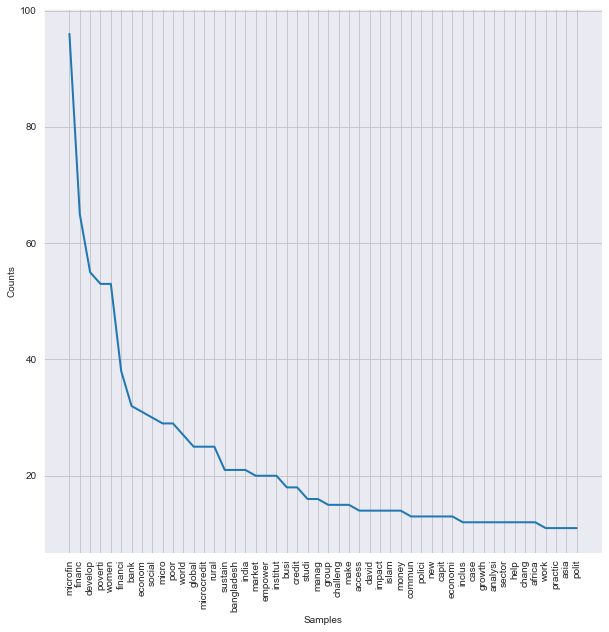

There are 58 most-frequently used words where min. frequency is set to 10
range of edge weights: 38 to 5
# of edges = 20
# of nodes = 16
network density = 0.167

*** CENTRALITY MEASURES, sorted by degree centrality
NODE         DEG.CENT.  EIG.CENT.  BTW.CENT. 
financ       0.733      0.578      0.814     
micro        0.4        0.406      0.362     
women        0.267      0.381      0.024     
microfin     0.2        0.335      0.0       
credit       0.133      0.132      0.0       
microcredit  0.133      0.132      0.0       
econom       0.133      0.151      0.133     
empower      0.133      0.235      0.0       
access       0.067      0.142      0.0       
develop      0.067      0.1        0.0       
economi      0.067      0.037      0.0       
financi      0.067      0.142      0.0       
institut     0.067      0.142      0.0       
poor         0.067      0.142      0.0       
rural        0.067      0.142      0.0       
social       0.067      0.142      0.0       


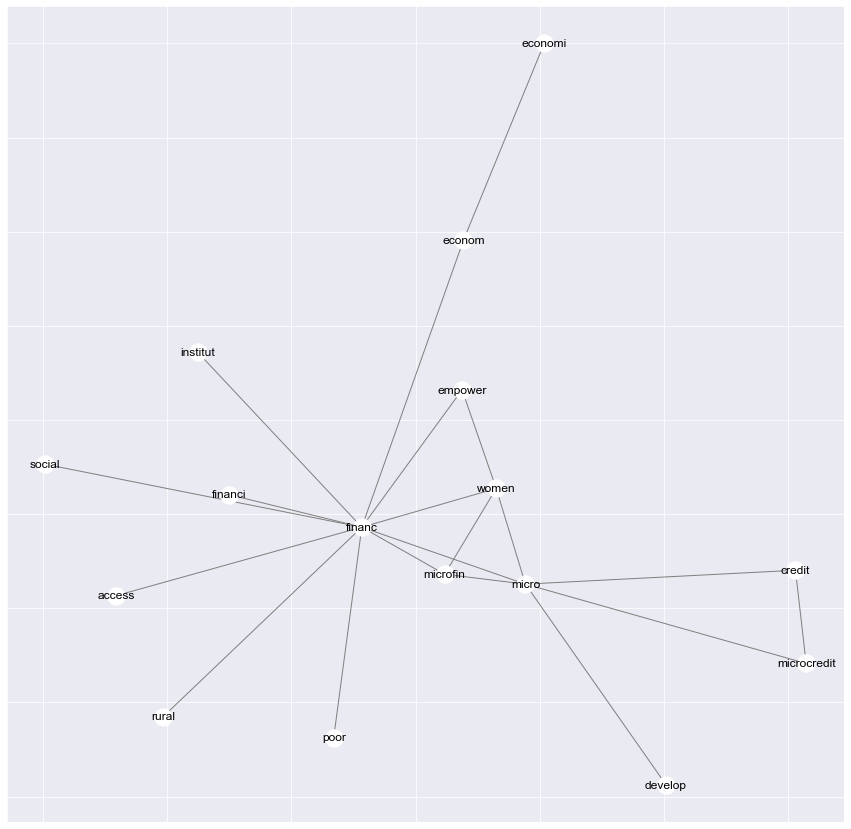

In [125]:
# Semantic Network Analysis 1: All Titles - Female 1st author

(wordlist, titles) = DataPrep(alldata, CATEGORY1='mainTitle', CATEGORY2='F', MIN_FREQ=10, PLOT=1)
netdata = AdjacenyData(wordlist, titles, MIN_WEIGHT = 5)
PlotNetwork(netdata)

50 most frequently used words


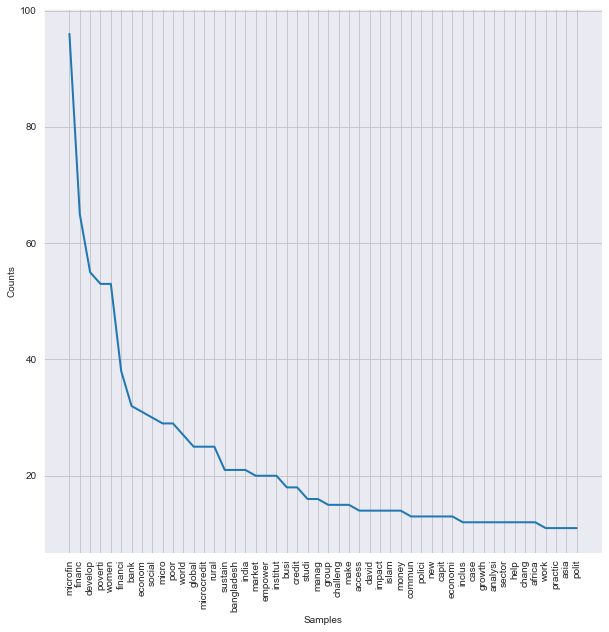

There are 58 most-frequently used words where min. frequency is set to 10
range of edge weights: 50 to 5
# of edges = 35
# of nodes = 23
network density = 0.138

*** CENTRALITY MEASURES, sorted by degree centrality
NODE         DEG.CENT.  EIG.CENT.  BTW.CENT. 
financ       0.773      0.56       0.572     
micro        0.455      0.431      0.109     
financi      0.182      0.255      0.006     
microfin     0.182      0.267      0.001     
credit       0.136      0.201      0.02      
develop      0.136      0.209      0.004     
econom       0.136      0.163      0.002     
institut     0.136      0.228      0.0       
analysi      0.091      0.18       0.0       
microcredit  0.091      0.115      0.0       
economi      0.091      0.131      0.0       
women        0.091      0.105      0.078     
inclus       0.091      0.148      0.0       
poor         0.091      0.18       0.0       
work         0.091      0.18       0.0       
group        0.091      0.0        0.004     
ban

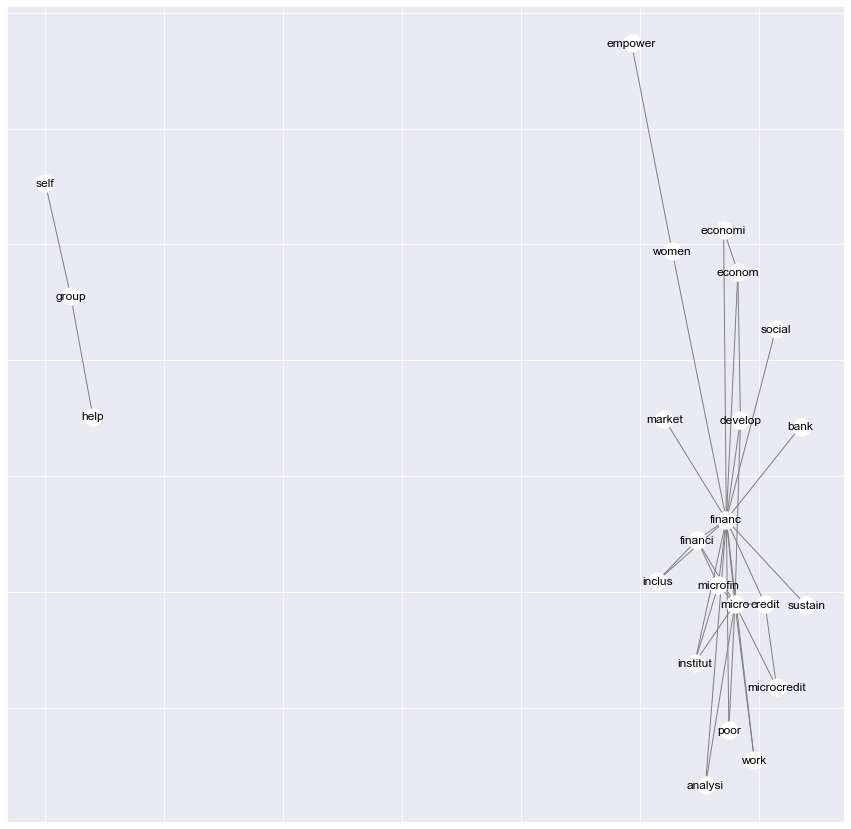

In [127]:
# Semantic Network Analysis 2: All Titles - Male 1st author

(wordlist, titles) = DataPrep(alldata, CATEGORY1='mainTitle', CATEGORY2='M', MIN_FREQ=10, PLOT=1)
netdata = AdjacenyData(wordlist, titles, MIN_WEIGHT = 5)
PlotNetwork(netdata)

50 most frequently used words


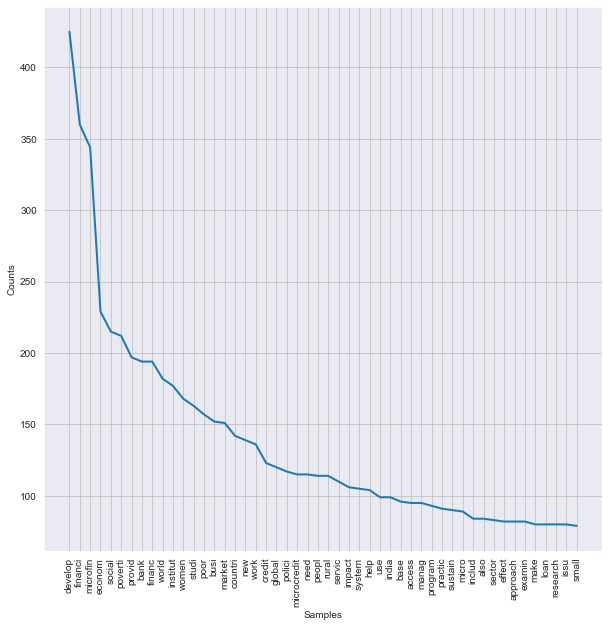

There are 49 most-frequently used words where min. frequency is set to 80
range of edge weights: 81 to 15
# of edges = 167
# of nodes = 43
network density = 0.185

*** CENTRALITY MEASURES, sorted by degree centrality
NODE         DEG.CENT.  EIG.CENT.  BTW.CENT. 
micro        0.929      0.361      0.315     
financ       0.905      0.356      0.311     
develop      0.69       0.312      0.151     
financi      0.524      0.279      0.041     
microfin     0.476      0.264      0.032     
work         0.405      0.249      0.013     
econom       0.333      0.224      0.006     
use          0.286      0.2        0.005     
institut     0.214      0.176      0.0       
provid       0.214      0.176      0.0       
poor         0.19       0.16       0.0       
women        0.19       0.155      0.0       
world        0.167      0.139      0.0       
bank         0.143      0.133      0.0       
credit       0.143      0.114      0.004     
global       0.143      0.122      0.0       
s

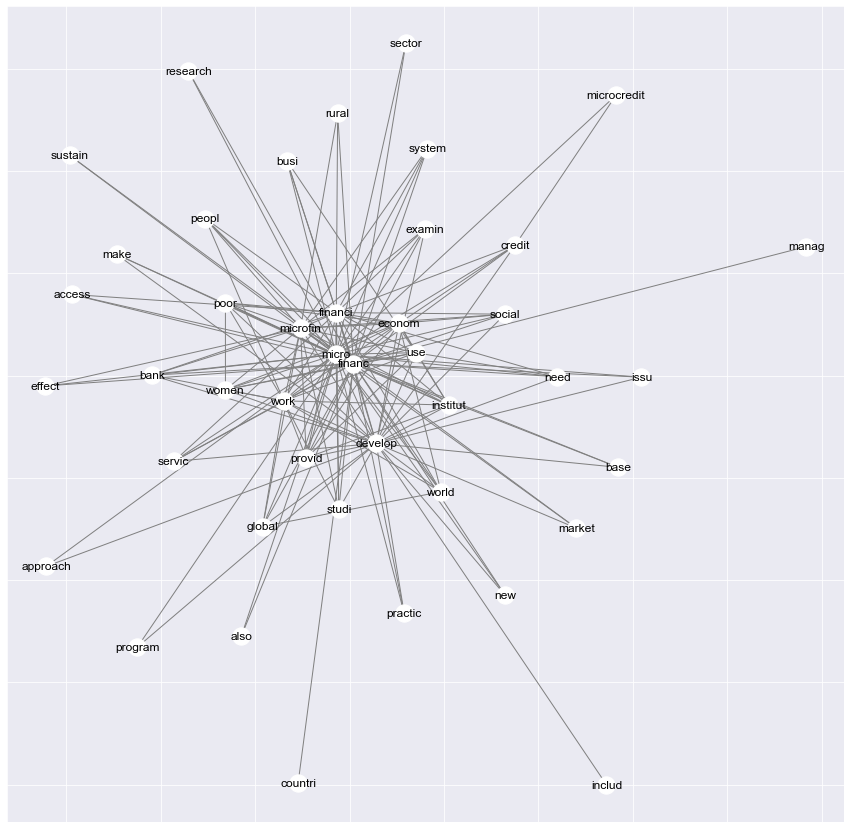

In [128]:
# Semantic Network Analysis 3: All Summaries - Female 1st author

(wordlist, titles) = DataPrep(alldata, CATEGORY1='Summary', CATEGORY2='F', MIN_FREQ=80, PLOT=1)
netdata = AdjacenyData(wordlist, titles, MIN_WEIGHT = 15)
PlotNetwork(netdata)

50 most frequently used words


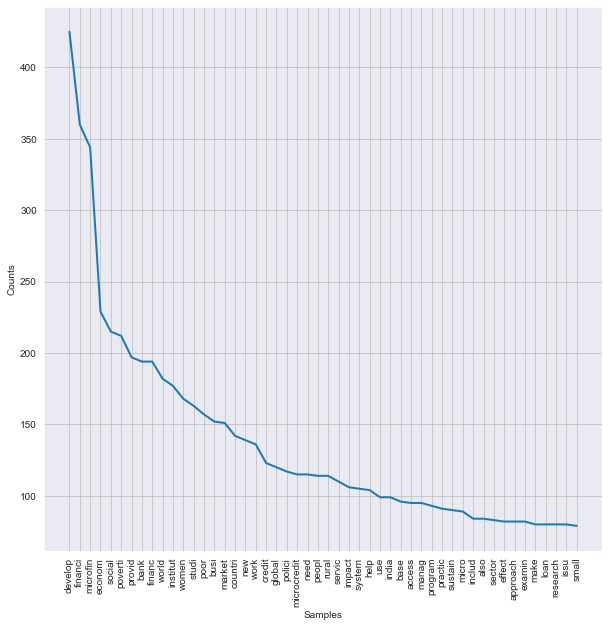

There are 49 most-frequently used words where min. frequency is set to 80
range of edge weights: 122 to 15
# of edges = 403
# of nodes = 46
network density = 0.389

*** CENTRALITY MEASURES, sorted by degree centrality
NODE         DEG.CENT.  EIG.CENT.  BTW.CENT. 
financ       1.0        0.25       0.11      
micro        1.0        0.25       0.11      
develop      0.956      0.246      0.091     
econom       0.911      0.24       0.078     
financi      0.889      0.238      0.07      
provid       0.844      0.236      0.05      
work         0.733      0.217      0.031     
microfin     0.667      0.205      0.022     
use          0.667      0.21       0.018     
world        0.644      0.207      0.014     
institut     0.578      0.191      0.01      
poor         0.556      0.185      0.011     
credit       0.511      0.172      0.01      
social       0.489      0.172      0.005     
new          0.444      0.161      0.003     
need         0.444      0.166      0.001     


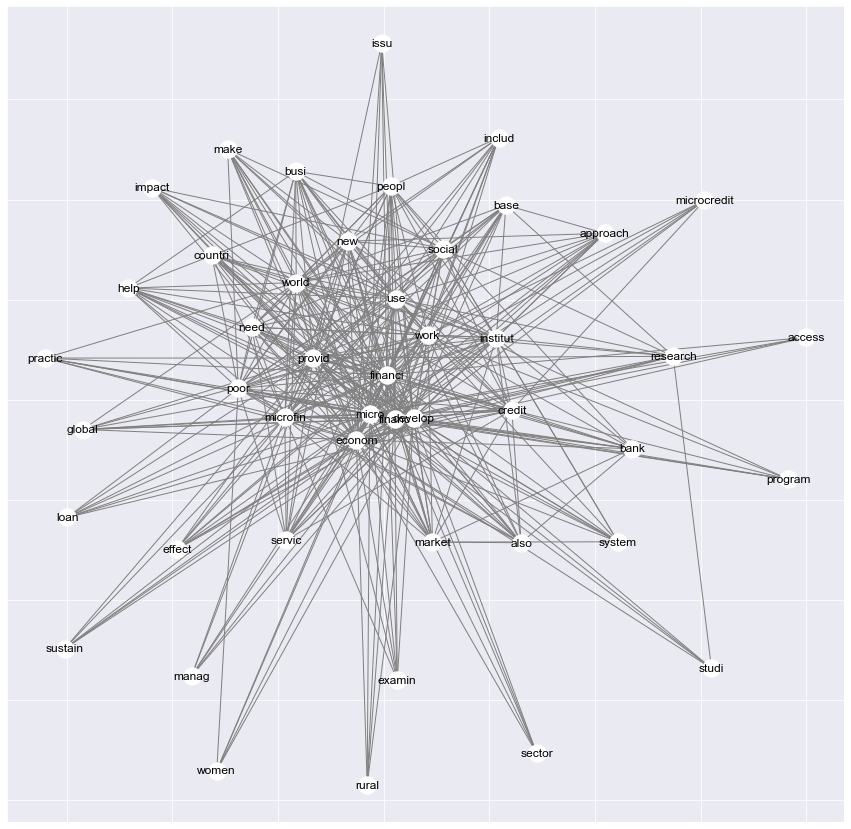

In [130]:
# Semantic Network Analysis 1: All Summaries - Male 1st author

(wordlist, titles) = DataPrep(alldata, CATEGORY1='Summary', CATEGORY2='M', MIN_FREQ=80, PLOT=1)
netdata = AdjacenyData(wordlist, titles, MIN_WEIGHT = 15)
PlotNetwork(netdata)